# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange
from scipy.special import logit, expit
from PolicyGradientAgent import StochasticGradientAgent
from Environment import *

In [15]:
learning_rate_theta = 1e-4
learning_rate_wv = 1e-4
memory_size = 1024
batch_size = 1024
training_episodes = 900000
decay_rate = 0
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
learning_std = False
fixed_std = 0.3
# Bucket parameters
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3
prior_red_list = [3/4, 1/4]

agent1 = StochasticGradientAgent(feature_shape=[1, 3], learning_rate_theta=learning_rate_theta,
                                learning_rate_wv=learning_rate_wv, 
                                memory_size= memory_size, batch_size=batch_size,
                                beta1=beta1, beta2=beta2, 
                                learning_std=learning_std, fixed_std=fixed_std)

agent2 = StochasticGradientAgent(feature_shape=[1, 3], learning_rate_theta=learning_rate_theta,
                                learning_rate_wv=learning_rate_wv, 
                                memory_size= memory_size, batch_size=batch_size,
                                beta1=beta1, beta2=beta2, 
                                learning_std=learning_std, fixed_std=fixed_std)

agent1.evaluation_init(pr_red_ball_red_bucket=pr_red_ball_red_bucket, pr_red_ball_blue_bucket=pr_red_ball_blue_bucket)
agent2.evaluation_init(pr_red_ball_red_bucket=pr_red_ball_red_bucket, pr_red_ball_blue_bucket=pr_red_ball_blue_bucket)

for t in tnrange(training_episodes):
    prior_red = np.random.choice(prior_red_list)
#     prior_red = np.random.uniform()
    bucket = Bucket(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
    pm = PredictionMarket(prior_red=prior_red)
    
    signal1 = bucket.signal()
    x1 = one_hot_encode(signal1)
    x1.append(logit(prior_red))
    h1, mean1, std1 = agent1.report(x1)
    pi1 = expit(h1)
    report1 = [pi1, 1 - pi1]
    pm.report(report1)
    R1 = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    signal2 = bucket.signal()
    x2 = one_hot_encode(signal2)
    x2.append(pi1)
    h2, mean2, std2 = agent2.report(x2)
    pi2 = expit(h2)
    report2 = [pi2, 1 - pi2]
    pm.report(report2)
    R2 = pm.log_resolve(bucket_colour_to_num[bucket.colour])

    agent1.store_experience(x1, h1, mean1, std1, R1, t)
    agent2.store_experience(x2, h2, mean2, std2, R2, t)

    try:
        agent1.batch_update(t, algorithm= algorithm)
        agent2.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)

    agent1.learning_rate_decay(epoch=t, decay_rate=decay_rate)
    agent2.learning_rate_decay(epoch=t, decay_rate=decay_rate)


  0%|          | 0/900000 [00:00<?, ?it/s]

learning_rate_theta= 0.0001  learning_rate_wv= 0.0001
memory_size= 1024  standard deviation= 0.3
Updating weights with regular algorithm.
learning_rate_theta= 0.0001  learning_rate_wv= 0.0001
memory_size= 1024  standard deviation= 0.3
Updating weights with regular algorithm.


In [27]:
reward_history_df1 = pd.DataFrame(agent1.reward_history_list, columns=['signal', 'prior_red', 'actual_reward', 'estimated_average_reward'])
report_history_df1 = pd.DataFrame(agent1.report_history_list, columns=['report', 'mean', 'std', 'signal'])
grad_mean_history_df1 = pd.DataFrame(agent1.mean_gradients_history_list,
                                            columns=['red_ball', 'blue_ball', 'prior'])
mean_weights_history_df1 = pd.DataFrame(agent1.mean_weights_history_list,
                                               columns=['red_weight', 'blue_weight', 'prior_weight'])

reward_history_df2 = pd.DataFrame(agent2.reward_history_list, columns=['signal', 'prior_red', 'actual_reward', 'estimated_average_reward'])
report_history_df2 = pd.DataFrame(agent2.report_history_list, columns=['report', 'mean', 'std', 'signal'])
grad_mean_history_df2 = pd.DataFrame(agent2.mean_gradients_history_list,
                                            columns=['red_ball', 'blue_ball', 'prior'])
mean_weights_history_df2 = pd.DataFrame(agent2.mean_weights_history_list,
                                               columns=['red_weight', 'blue_weight', 'prior_weight'])

In [49]:
report_history_df1

,report,mean,std,signal
0,0.520843,0.000000,0.3,blue
1,0.486003,-0.000092,0.3,blue
2,0.519900,-0.000112,0.3,blue
3,0.459619,-0.000081,0.3,red
4,0.457699,0.000092,0.3,red
...,...,...,...,...
899995,0.836229,1.774938,0.3,red
899996,0.743680,0.416264,0.3,blue
899997,0.623205,0.416261,0.3,blue
899998,0.151939,-1.736601,0.3,blue


In [50]:
reward_history_df1

,signal,prior_red,actual_reward,estimated_average_reward
0,blue,1.098612,-0.448045,0.000000
1,blue,1.098612,-0.377856,-0.000099
2,blue,1.098612,-0.366437,-0.000190
3,red,1.098612,-0.489675,-0.000152
4,red,-1.098612,0.774361,0.000190
...,...,...,...,...
899995,red,1.098612,-1.521606,-0.237322
899996,blue,1.098612,-1.073648,-0.241399
899997,blue,1.098612,-0.688371,-0.241398
899998,blue,-1.098612,1.221491,0.854744


<AxesSubplot:ylabel='Frequency'>

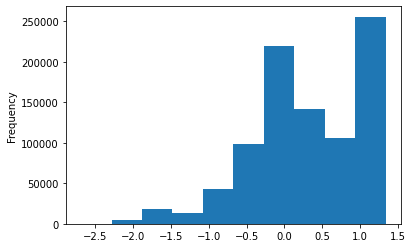

In [55]:
reward_history_df1.actual_reward.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

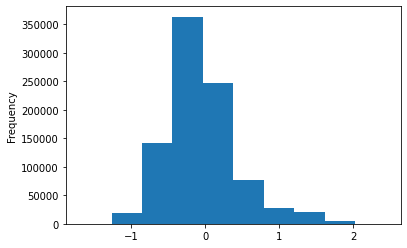

In [54]:
reward_history_df2.actual_reward.plot(kind='hist')

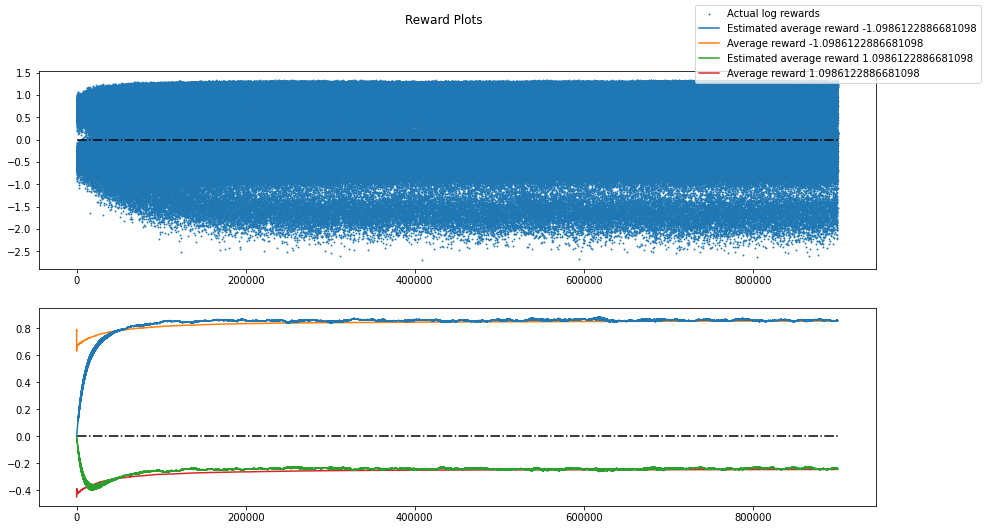

In [16]:
agent1.reward_history_plot()

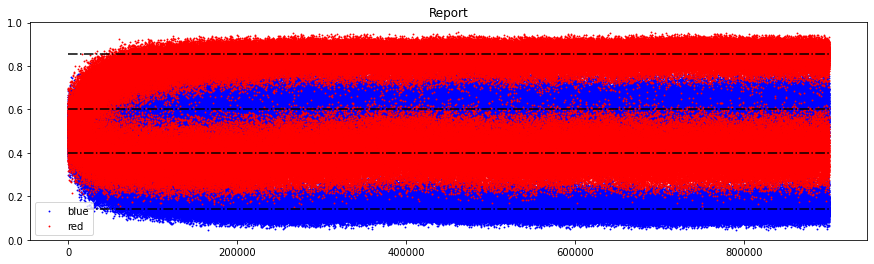

In [17]:
agent1.report_history_plot(prior_red_list=prior_red_list)

In [18]:
def phase_change_coordinates(mark_index, df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    coord_list = []
    prev_x = 0
    for x in mark_index:
        if x > 50:
            if x > prev_x + 1000:
                coord_list.append((x, df.select_dtypes(include=numerics).loc[x, :].max()))
                prev_x = x
    return coord_list

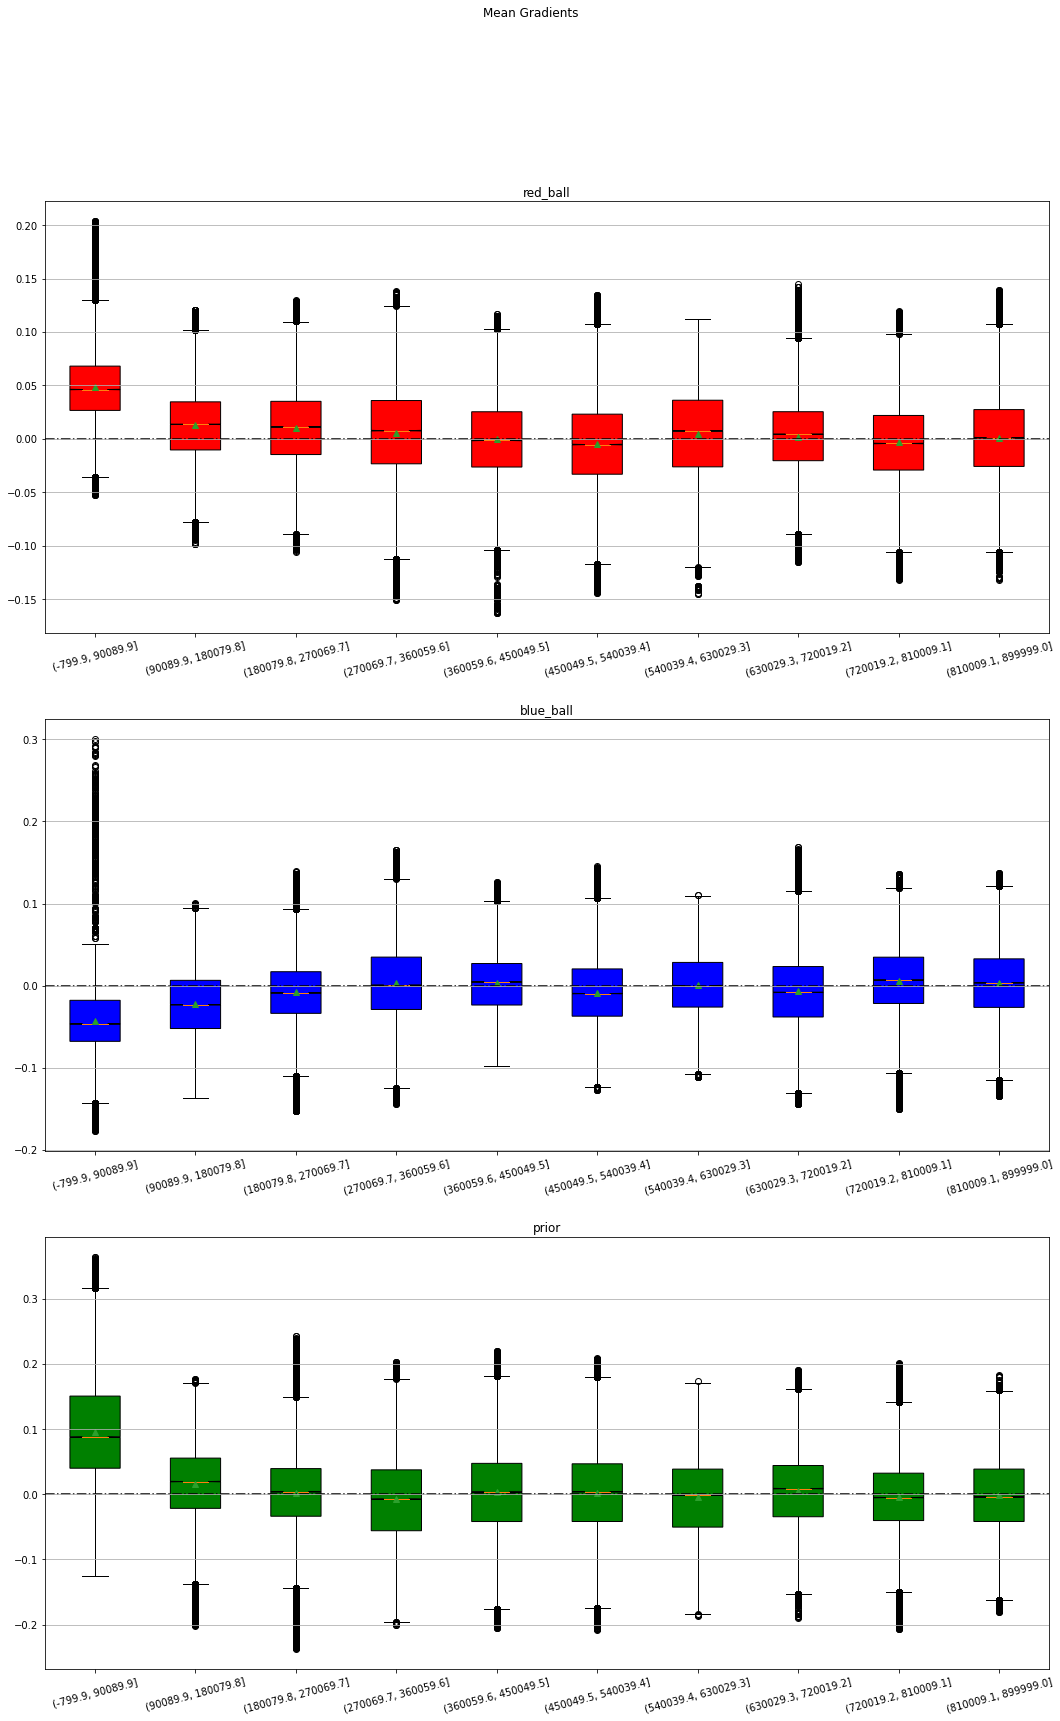

In [19]:
agent1.mean_gradients_history_plot()



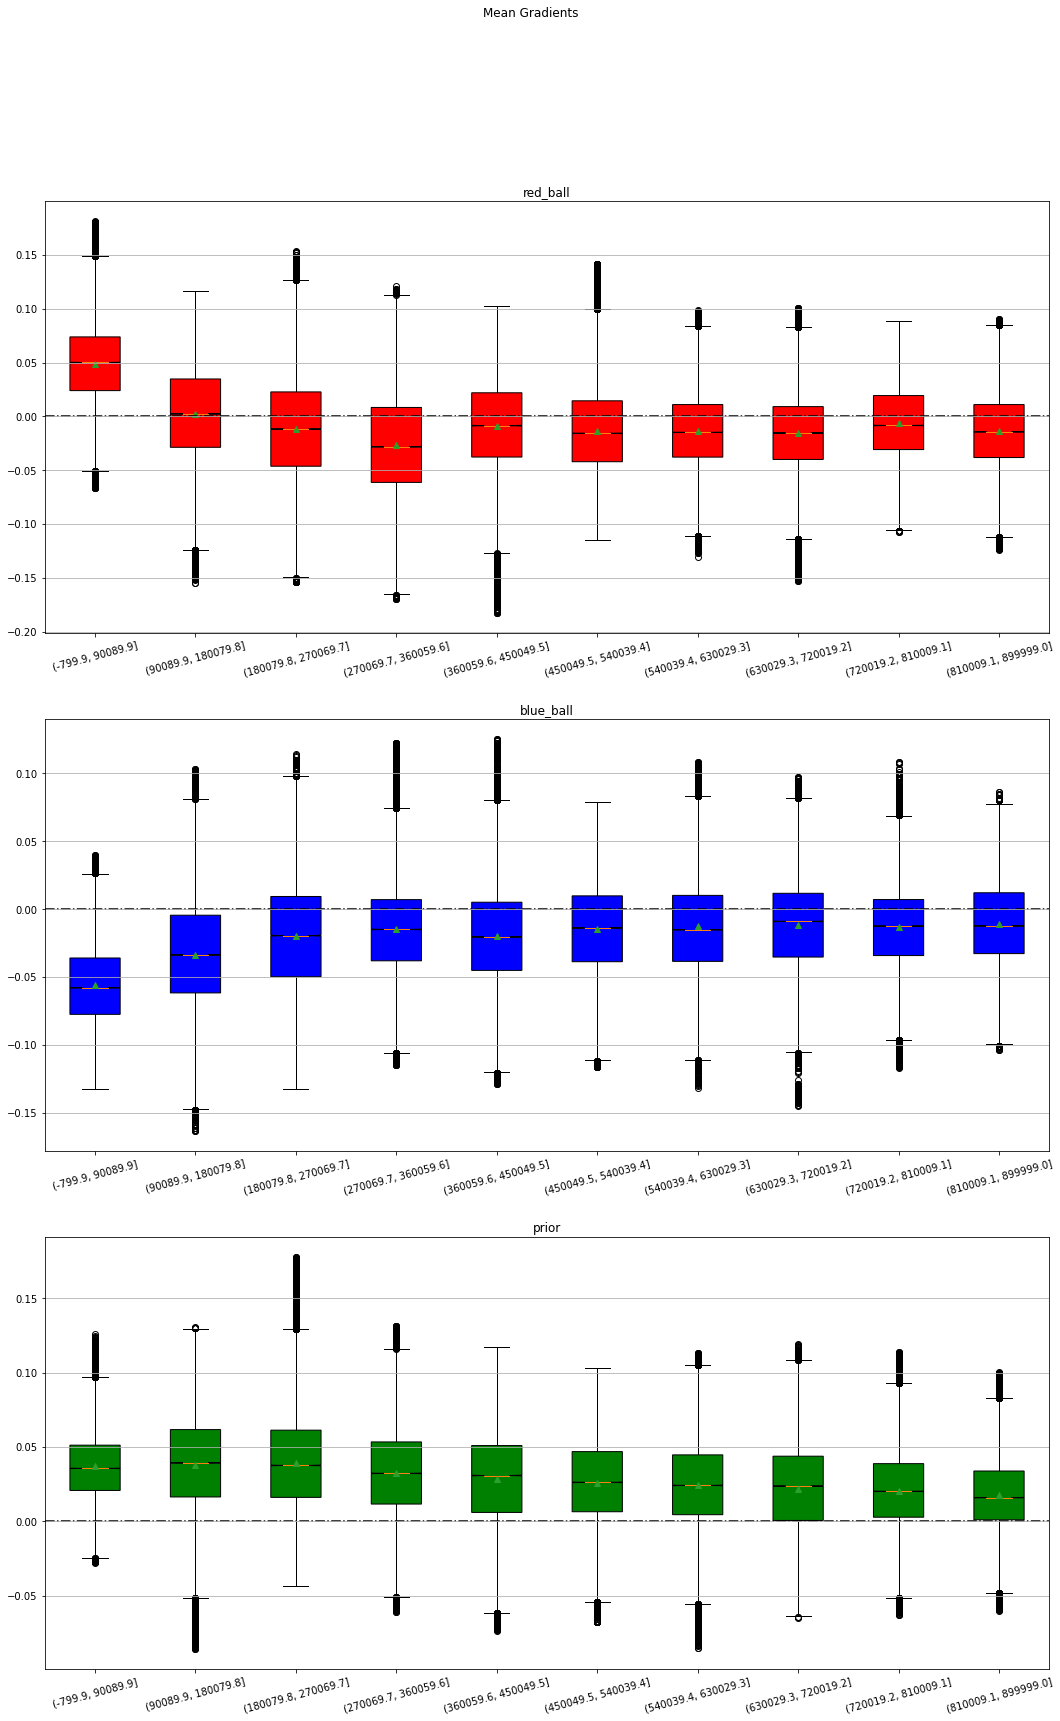

In [20]:
agent2.mean_gradients_history_plot()

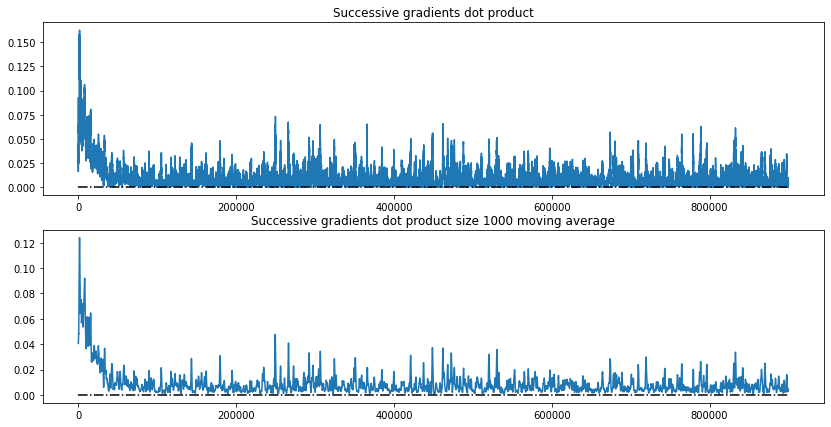

In [21]:
agent1.mean_gradients_successive_dot_product_plot()

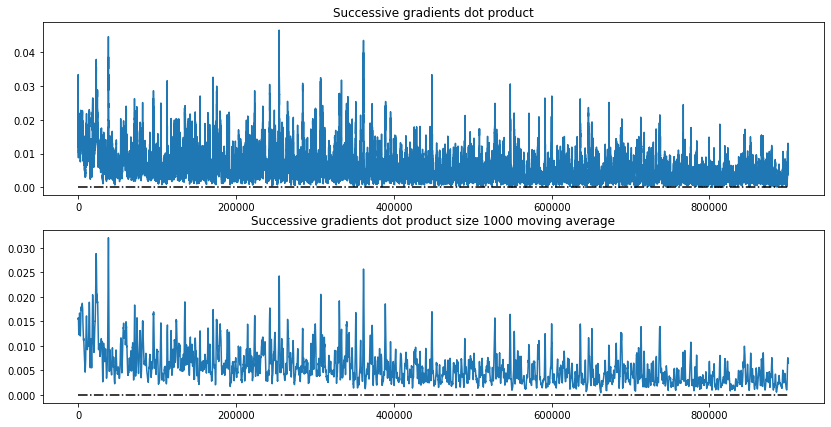

In [22]:
agent2.mean_gradients_successive_dot_product_plot()

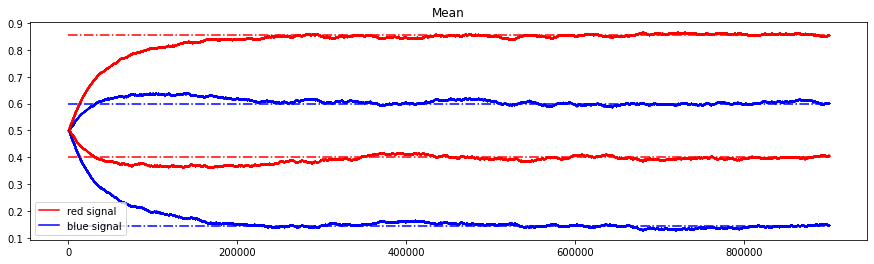

In [23]:
agent1.mean_history_plot(prior_red_list=prior_red_list)

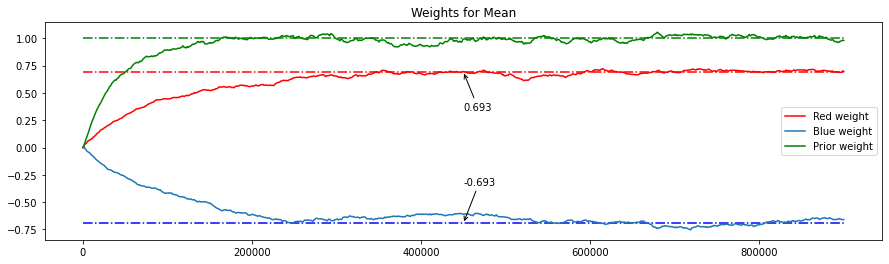

In [24]:
agent1.mean_weights_history_plot()

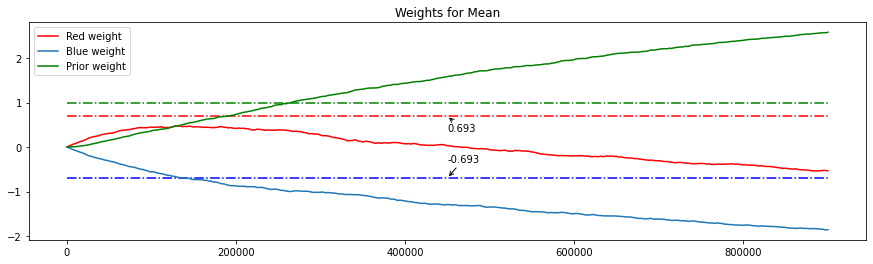

In [25]:
agent2.mean_weights_history_plot()

In [26]:
def pd_table_to_fig(data, title, footer='', fig_background_color='skyblue', fig_border='steelblue'):
    rcolors = plt.cm.BuPu(np.full(len(data.index), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(data.columns), 0.1))
    # Create the figure. Setting a small pad on tight_layout
    # seems to better regulate white space. Sometimes experimenting
    # with an explicit figsize here can produce better outcome.
    plt.figure(linewidth=2,
               edgecolor=fig_border,
               facecolor=fig_background_color,
               tight_layout={'pad':1},
               figsize=(10,6)
              )
    # Hide axes
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    the_table = pd.plotting.table(ax=ax, data=data,
                                  rowColours=rcolors,
                                  rowLoc='right',
                                  colColours=ccolors,
                                  loc='center')
    the_table.scale(1, 1.5)
    # Hide axes border
    plt.box(on=None)
    # Add title
    plt.suptitle(title)
    # Add footer
    plt.figtext(0.95, 0.05, footer, horizontalalignment='right', size=6, weight='light')
    # Force the figure to update, so backends center objects correctly within the figure.
    # Without plt.draw() here, the title will center on the axes and not the figure.
    plt.draw()
    # Create image. plt.savefig ignores figure edge and face colors, so map them.
    fig = plt.gcf()
    

query_index = mean_weights_history_df.shape[0]//3
pd_table_to_fig(data=mean_weights_history_df.iloc[-query_index:, :].describe(), title='Mean Weights Summary', footer='')

NameError: name 'mean_weights_history_df' is not defined

In [ ]:
mean_weights_history_df.iloc[-query_index:, :].describe()

In [ ]:
if learning_std:
    min_std = report_history_df['std'].min()
    fig, ax = plt.subplots(figsize=(15, 4))
    for signal, df in report_history_df.reset_index().groupby('signal'):
        ax.scatter(x=df['index'], y=df['std'], label=signal, marker='.', c=signal, s=0.1)
    plt.hlines(y=0, xmin=0, xmax=len(report_history_df) , colors='black', linestyles='dashdot')
    plt.hlines(y=min_std, xmin=0, xmax=len(report_history_df) , colors='black', linestyles='dashdot', label=str(min_std))
    red_line = mlines.Line2D([], [], color='red', label='red signal')
    blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
    ax.legend(handles=[red_line, blue_line])
    plt.title('Standard Diviation')
